## Importance Sampling

Target density function can be defined as $ Pr( \left \| x \right \|_\frac{1}{2} \leq  1 ) $. Inspiring from the paper[1] and the post[2], I used the probability density function of multivariate gaussian distribution as proposal. Then, my proposal becomes $ \frac{1}{\sqrt{(2\pi)\left |  \Sigma  \right |}}exp(-\frac{1}{2}(x-\mu )^{\tau }\Sigma^{-1}(x-\mu )) $ where $\Sigma$ is covariance matrix and $\mu$  is the mean value. 

Then weight function, $w(x) = \frac{\pi (x)}{q(x)}$ is equal to 0 if $ Pr( \left \| x \right \|_\frac{1}{2} \leq  1 ) = 0 $ ;  $\frac{1}{q(x)}$ otherwise. 

Hencefort, The only thing to do is computing expectations by reweighting generated points with respect to the proposal function. Then the area calculation comes into play, reweighted points are averaged to estimate the area of 0.5-norm closed unit ball.

Note: covariance matrix is determined as [[0.1,0], [0,0.1]] because it yields minimum variance.

[1] : http://iacs-courses.seas.harvard.edu/courses/iacs_projects/BenCookCorn/am207/assets/pdf/cook-am207.pdf

[2] : http://math.stackexchange.com/questions/145980/probability-that-a-multivariate-normal-rv-lies-within-a-spherical-region-of-radi

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import math
import seaborn as sns

N = 1000
p = 0.5
mean = np.array(np.zeros(shape=2))
cov = [[0.1,0],[0,0.1]]

In [2]:
def pNormUnitBallCondition(v,p):
    return np.power((np.power(np.abs(v[0]),p) + np.power(np.abs(v[1]),p)),1.0/p) <= float(1.0)

In [40]:
## importance sampling from p-norm unit ball 
## my proposal will be the normalized multivariate gaussian distribution with mean = [0,0] 
## and covariance matrix = [[0.1,0], [0,1.0]]

def proposal(v):
    return multivariate_normal.pdf(v,mean,cov)

def weightFunction(v,p):
    if pNormUnitBallCondition(v,p):
        return (1.0 / proposal(v))
    else:
        return 0
def area():
    randomVectors = np.random.multivariate_normal(mean,cov,N)
    weights = [weightFunction(v,p) for v in randomVectors]
    return np.mean(weights)

#area estimation
areaEstimations = [area() for i in range(5)]
print("Estimated area for N=" + str(N) + ": " + str(np.mean(areaEstimations)))

Estimated area for N=1000: 0.65139189791


In [41]:
variance = np.var(areaEstimations)
print("Variance N=" + str(N) + ": " + str(variance))

Variance N=1000: 0.000533327091328


## Markov Chains

a) Transition matrix corresponding to the game can be defined as
$$ \begin{pmatrix}
 &.25  &.25  &.25  &.25  &.25  &.25\\ 
 &0       &.25  &0  &0  &.25 &0 \\ 
 &0       &0  &0  &0.5  &0  &0\\ 
 &.25  &.25  &.5  &0  &.25  &.25\\ 
 &.25  &.25  &.25  &.25  &.25  &.25\\ 
 &.25  &0  &0  &0  &0  &.25\\
\end{pmatrix} $$

Where colums are the transition vectors from state $\chi _{t-1} $ to $\chi _{t}$

In [21]:
transitionMatrix = np.array([
    [0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
    [0,    0.25, 0,    0,    0.25, 0   ],
    [0,    0,    0,    0.5,  0,    0   ],
    [0.25, 0.25, 0.5,  0,    0.25, 0.25],
    [0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
    [0.25, 0,    0,    0,    0,    0.25]
])

b) In this case, the stationary distribution is not uniform distribution.(Also it does not satisfy detailed balance condition)

In [200]:
eigenValues, eigenVectors = np.linalg.eig(np.transpose(transitionMatrix))
#print("Eigen values: " + str(eigenValues))
#print("Eigen vectors:")
#print("" + str(eigenVectors))

projectionMatrix = np.matrix(eigenVectors)
projectionMatrix = np.transpose(projectionMatrix)
projectionMatrixInv = np.linalg.inv(projectionMatrix)
diagonaleMatrix = np.diag(eigenValues)

#print("Diagonale matrix:")
#print("" + str(diagonaleMatrix))

def powerOfMatrix(p):
    return np.matrix(projectionMatrixInv * np.linalg.matrix_power(diagonaleMatrix,p) * projectionMatrix)

stationaryMatrix = powerOfMatrix(100)
stationaryDistVector = stationaryMatrix[:,0]
print("Stationary distribution:")
print("")
print("" + str(stationaryMatrix))
print("Stationary distribution (as vector):")
print("")
print("" + str(stationaryDistVector))

#print("Projection matrix:")
#print("" + str(projectionMatrix))

Stationary distribution:

[[ 0.25        0.25        0.25        0.25        0.25        0.25      ]
 [ 0.08333333  0.08333333  0.08333333  0.08333333  0.08333333  0.08333333]
 [ 0.11111111  0.11111111  0.11111111  0.11111111  0.11111111  0.11111111]
 [ 0.22222222  0.22222222  0.22222222  0.22222222  0.22222222  0.22222222]
 [ 0.25        0.25        0.25        0.25        0.25        0.25      ]
 [ 0.08333333  0.08333333  0.08333333  0.08333333  0.08333333  0.08333333]]
Stationary distribution (as vector):

[[ 0.25      ]
 [ 0.08333333]
 [ 0.11111111]
 [ 0.22222222]
 [ 0.25      ]
 [ 0.08333333]]


c) This distribution does not satisfy the detailed balance condition. As an example, I computed transitions from state 3 to 4 and state 4 to 3.

In [5]:
#state transition from state 3 to 4
def satisfyDetailedBalance():
    p3to4 = 0.25
    p4to3 = 0.5
    piOf3 = [0.25, 0, 0, 0.5, 0.25, 0]
    piOf4 = [0.25, 0, 0.5, 0, 0.25, 0]
    result1 = [i*p3to4 for i in piOf3]
    result2 = [i*p4to3 for i in piOf4]
    #print("Result 1: " + str(result1) )
    #print("Result 2: " + str(result2) )
    return result1 == result2

print("Satisfy detailed balance?: " + str(satisfyDetailedBalance()))  

Satisfy detailed balance?: False


d) Tmix value is 25 in this distribution.

In [202]:
epsilon = 1e-8
x_0 = np.array([[1],[0],[0],[0],[0],[0]])
Tmix = 0
def valTmix(e):
    x = np.dot(np.matrix(transitionMatrix), np.matrix(x_0))
    variationDistance = np.linalg.norm(np.matrix(x)-np.matrix(x_0),1)*0.5
    t_mix = 1;
    while(variationDistance > e):
        x_ = np.dot(np.matrix(transitionMatrix), np.matrix(x))
        variationDistance = np.linalg.norm(np.matrix(x)-np.matrix(x_),1)*0.5 #total variation norm.
        x = x_
        t_mix += 1
    print("Tmix: " + str(t_mix))
    return tMix;
        
Tmix = valTmix(epsilon)    
    

Tmix: 25


e)

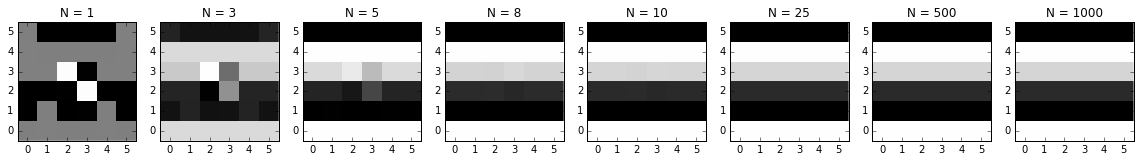

In [64]:
f, ax = plt.subplots(1,8, figsize=(20,20))
for i,n in enumerate([1,3,5,8,10,25,500,1000]):
    ax[i].set_title("N = "+ str(n))
    ax[i].imshow(np.linalg.matrix_power(np.matrix(transitionMatrix),n), 'gray', origin='lower',interpolation='none')
    

f) Sampling independent chains

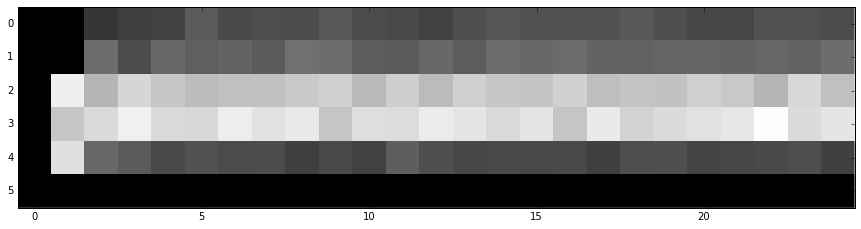

In [239]:
def independentChain(state, tmix):
    samples= []
    for i in range(tmix):
        samples.append(state)
        state = np.random.choice(range(6), p=transitionMatrix[:,state])
    #print(str(samples))
    return samples

def generateChains(n,state,tmix):
    chains = np.zeros([n, tmix])
    for i in range(n):
        chain = independentChain(state,tmix)
        chains[i][:] = chain
    #print(str(chains))
    return chains

def generateHistogramsOfChains(chainList,tmix,N):
    return np.array([[j for j in np.histogram(chainList[:,i], bins=range(1,8))[0][:]] for i in range(tmix)])
    

chains = generateChains(1000,0,25)
histogram = generateHistogramsOfChains(chains,25,1000)
#print(str(histogram))
# Plot the figure
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(histogram.T,'gray',interpolation='none')
plt.show()

g)

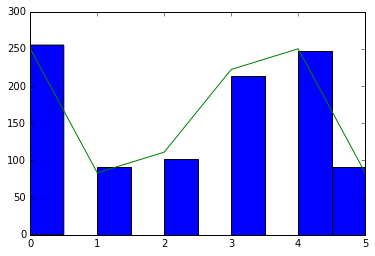

In [201]:
def singleChain(N,tmix):
    chain = []
    state = np.random.randint(6)
    for i in range(N + tmix):
        state = np.random.choice(range(6), p=transitionMatrix[:,state])
        if(i > tmix):
            chain.append(state)
    
    return chain;
        
plt.hist(singleChain(1000,25))        
plt.plot(range(6),stationaryDistVector*1000)    